In [1]:
from source_codes.ranking_model_ranksvm import ranking_alone_model_hp

def build_model(hp):
    hp_model = ranking_alone_model_hp(
        # feature extraction hyperparameters
        backbone='vgg19',
        backbone_weights='imagenet',

        # subnetwork hyperparameters
        r_num_dense=hp.Int('r_num_dense', max_value=4, min_value=2, step=1, default=2),
        r_dense_dropout=True,
        r_dense_units=hp.Int('r_dense_units', max_value=4096, min_value=512, step=512, default=1024),
        r_sub_dense_mode=hp.Choice('r_sub_dense_mode', ['parallel', 'decreasing'], default='decreasing'),
        r_dense_dropout_rate=hp.Float(name='r_dense_dropout_rate', max_value=0.5, min_value=0.1, step=0.1),
        r_l1=hp.Float('r_l1', max_value=1e-4, min_value=1e-6, step=10, sampling='log', default=1e-5),
        r_l2=hp.Float('r_l2', max_value=1e-4, min_value=1e-6, step=10, sampling='log', default=1e-5),

        # compilation hyperparameters
        optimizer=hp.Choice('optimizer', ['sgd', 'adam'], default='sgd'),
        decay=hp.Float('decay', max_value=1e-6, min_value=1e-8, step=10, sampling='log', default=1e-7),
        learning_rate=hp.Float('learning_rate', max_value=1e-6, min_value=1e-8, step=10, sampling='log', default=1e-7),
    )
    return hp_model


In [2]:

# prepare data
import numpy as np
import os

question_index = str(2)

# training data
x_left_training = np.load(
    os.path.join('data/ForModelTraining/train_data/draw_exclude/train_left_duel_' + question_index + '.npy'), allow_pickle=True)
x_right_training = np.load(
    os.path.join('data/ForModelTraining/train_data/draw_exclude/train_right_duel_' + question_index + '.npy'),
    allow_pickle=True)
y_training = np.load(os.path.join('data/ForModelTraining/train_data/draw_exclude/train_label_duel_' + question_index + '.npy'),
                     allow_pickle=True)

# validation data
x_left_val = np.load(
    os.path.join('data/ForModelTraining/validation_data/draw_exclude/val_left_duel_' + question_index + '.npy'),
    allow_pickle=True)
x_right_val = np.load(
    os.path.join('data/ForModelTraining/validation_data/draw_exclude/val_right_duel_' + question_index + '.npy'),
    allow_pickle=True)
y_val = np.load(os.path.join('data/ForModelTraining/validation_data/draw_exclude/val_label_duel_' + question_index + '.npy'),
                allow_pickle=True)

# test data
x_left_test = np.load(os.path.join('data/ForModelTraining/test_data/draw_exclude/test_left_duel_' + question_index + '.npy'),
                      allow_pickle=True)
x_right_test = np.load(os.path.join('data/ForModelTraining/test_data/draw_exclude/test_right_duel_' + question_index + '.npy'),
                       allow_pickle=True)
y_test = np.load(os.path.join('data/ForModelTraining/test_data/draw_exclude/test_label_duel_' + question_index + '.npy'),
                 allow_pickle=True)

In [4]:

# configure hp model
import keras_tuner as kt

build_model(kt.HyperParameters())

val_rank_accuracy_obj = kt.Objective("val_ranking_accuracy", direction="max")

hp_date = '053123'

tuner = kt.BayesianOptimization(
    build_model,
    objective=[val_rank_accuracy_obj],
    max_trials=24,
    executions_per_trial=4,
    overwrite=False,
    directory='model_results/Q2/hp_tuning',
    project_name="hptuning_ranking_" + hp_date,
)

In [5]:

# search hp model
from keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    mode='min',
    restore_best_weights=True
)

tuner.search(
    x=[x_left_training, x_right_training],
    y=y_training,
    epochs=80,
    batch_size=16,
    validation_data=([x_left_val, x_right_val], y_val),
    callbacks=[early_stopping]
)

# Get the top 10 hyperparameters results
tuner.results_summary()


Trial 25 Complete [02h 31m 57s]
multi_objective: -0.6359614282846451

Best multi_objective So Far: -0.6788105815649033
Total elapsed time: 2d 07h 04m 33s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in model_results/Q2/hp_tuning\hptuning_ranking_230521
Showing 10 best trials
Trial summary
Hyperparameters:
r_num_dense: 2
r_dense_units: 3072
r_sub_dense_mode: parallel
r_dense_dropout_rate: 0.1
r_l1: 9.999999999999999e-06
r_l2: 9.999999999999999e-06
optimizer: sgd
decay: 1e-07
learning_rate: 1e-07
Score: -0.6788105815649033
Trial summary
Hyperparameters:
r_num_dense: 3
r_dense_units: 1536
r_sub_dense_mode: parallel
r_dense_dropout_rate: 0.1
r_l1: 9.999999999999999e-05
r_l2: 1e-06
optimizer: adam
decay: 1e-07
learning_rate: 1e-06
Score: -0.6750637590885162
Trial summary
Hyperparameters:
r_num_dense: 2
r_dense_units: 2560
r_sub_dense_mode: decreasing
r_dense_dropout_rate: 0.1
r_l1: 9.999999999999999e-06
r_l2: 9.999999999999999e-05
optimizer: sgd
decay: 1e-07
learning_rate: 

In [6]:

# Get the top 5 weighted models.
models = tuner.get_best_models(num_models=5)
best_model = models[0]
best_model.summary()

# Save the best 5 models initialized with the best weights.
save_dir = 'model_results/Q2/hp_tuning/hptuning_ranking_230521'
for i in range(len(models)):
    models[i].save(os.path.join(save_dir, 'best_model_' + str(i) + '.h5'))

# save the best model architecture
best_hps = tuner.get_best_hyperparameters(5)
save_dir = "model_results/Q2/hp_tuning/hptuning_ranking_230521"

for i in range(len(best_hps)):
    model = build_model(best_hps[i])
    model.save(os.path.join(save_dir, 'best_model_' + str(i) + '_architecture.h5'))

Model: "Ranking_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_2[0][0]',                
                                                                  'input_3[0][0]']    

In [5]:
# retrain the best model from saved architecture
from keras import models,callbacks
from source_codes.ranking_models_hptunable import ranking_loss,ranking_accuracy
save_dir = "model_results/Q2/hp_tuning/hptuning_ranking_230521"
best_model_retrain = models.load_model(os.path.join(save_dir, 'best_model_0_architecture.h5'),custom_objects={'ranking_loss': ranking_loss,'ranking_accuracy':ranking_accuracy})
best_model_retrain.summary()

early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode='min',
    restore_best_weights=True
)

history = best_model_retrain.fit(
    x=[x_left_training, x_right_training],
    y=y_training,
    epochs=30,
    batch_size=32,
    validation_data=([x_left_val, x_right_val], y_val),
    callbacks=[early_stopping]
)

Model: "Ranking_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_5[0][0]',                
                                                                  'input_6[0][0]']    

In [7]:
best_model_retrain.evaluate([x_left_test, x_right_test], y_test)

28/28 [==============================] - 2s 66ms/step - loss: 94.6224 - ranking_accuracy: 0.6475


[94.62239074707031, 0.6474702954292297]

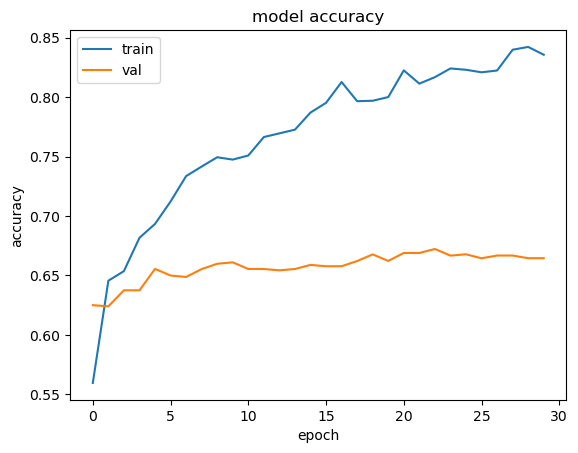

In [8]:
# plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['ranking_accuracy'])
plt.plot(history.history['val_ranking_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')